# Analysis 

We now perform the geometrical analyses over three different sets of prompts:

- Analysis of 10 prompts in a wide range of tokens (from 100 to 1000);
- Analysis of 10 prompts in a range of tokens around the total
embedding space dimension (768);
- Analysis of 10 prompts with the same number of tokens (100)
belonging to different semantic areas

In [1]:
# External classes
from BufferGeometry import BufferGeometry
from GeometryUtils import *

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la


import warnings
warnings.filterwarnings('ignore')

2025-07-15 10:29:42.930023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 10:29:42.965385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 100 to 1000 tokens prompts

We tried to generate 10 prompts with a number of tokens from 100 to 1000 all concerning the same topic to see how the geometry is influenced by the dimension of the input prompt

In [2]:
# Compute the interested geometrical quantities
volumes, gd, cos_sim, mean_vector, token_counts, rank_matrix = general_analysis("ai_prompts_100_to_1000_tokens.txt")

# Prepare data for the heatmap
gd_heatmap = get_heatmap("ai_prompts_100_to_1000_tokens.txt")

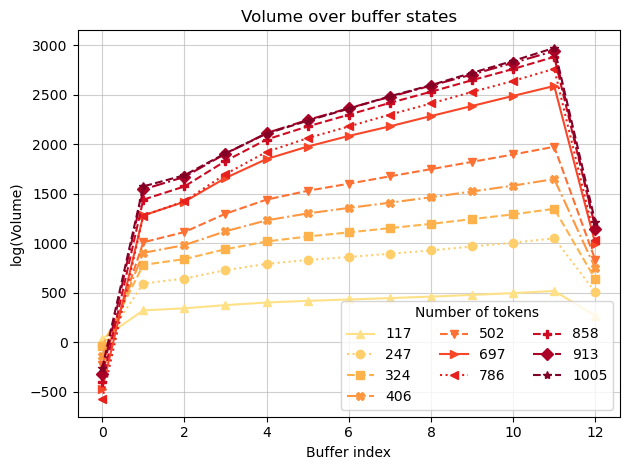

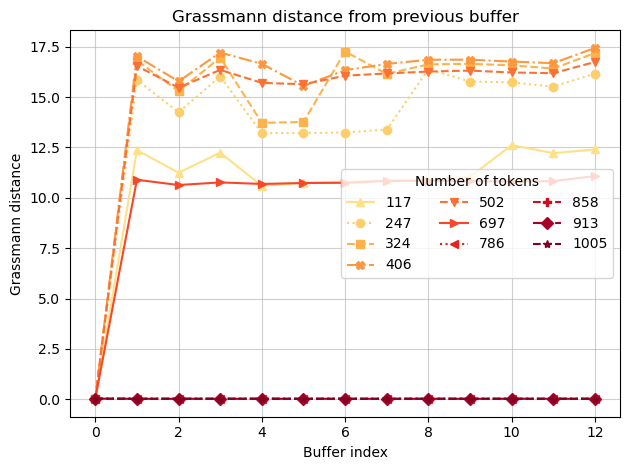

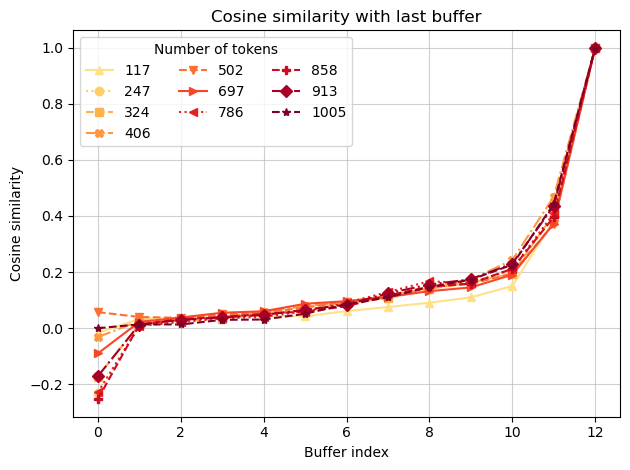

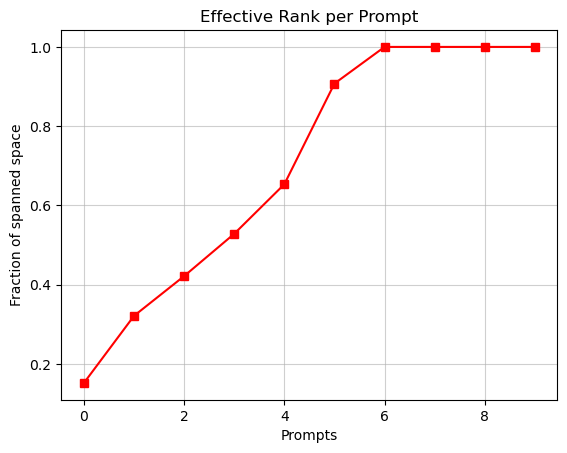

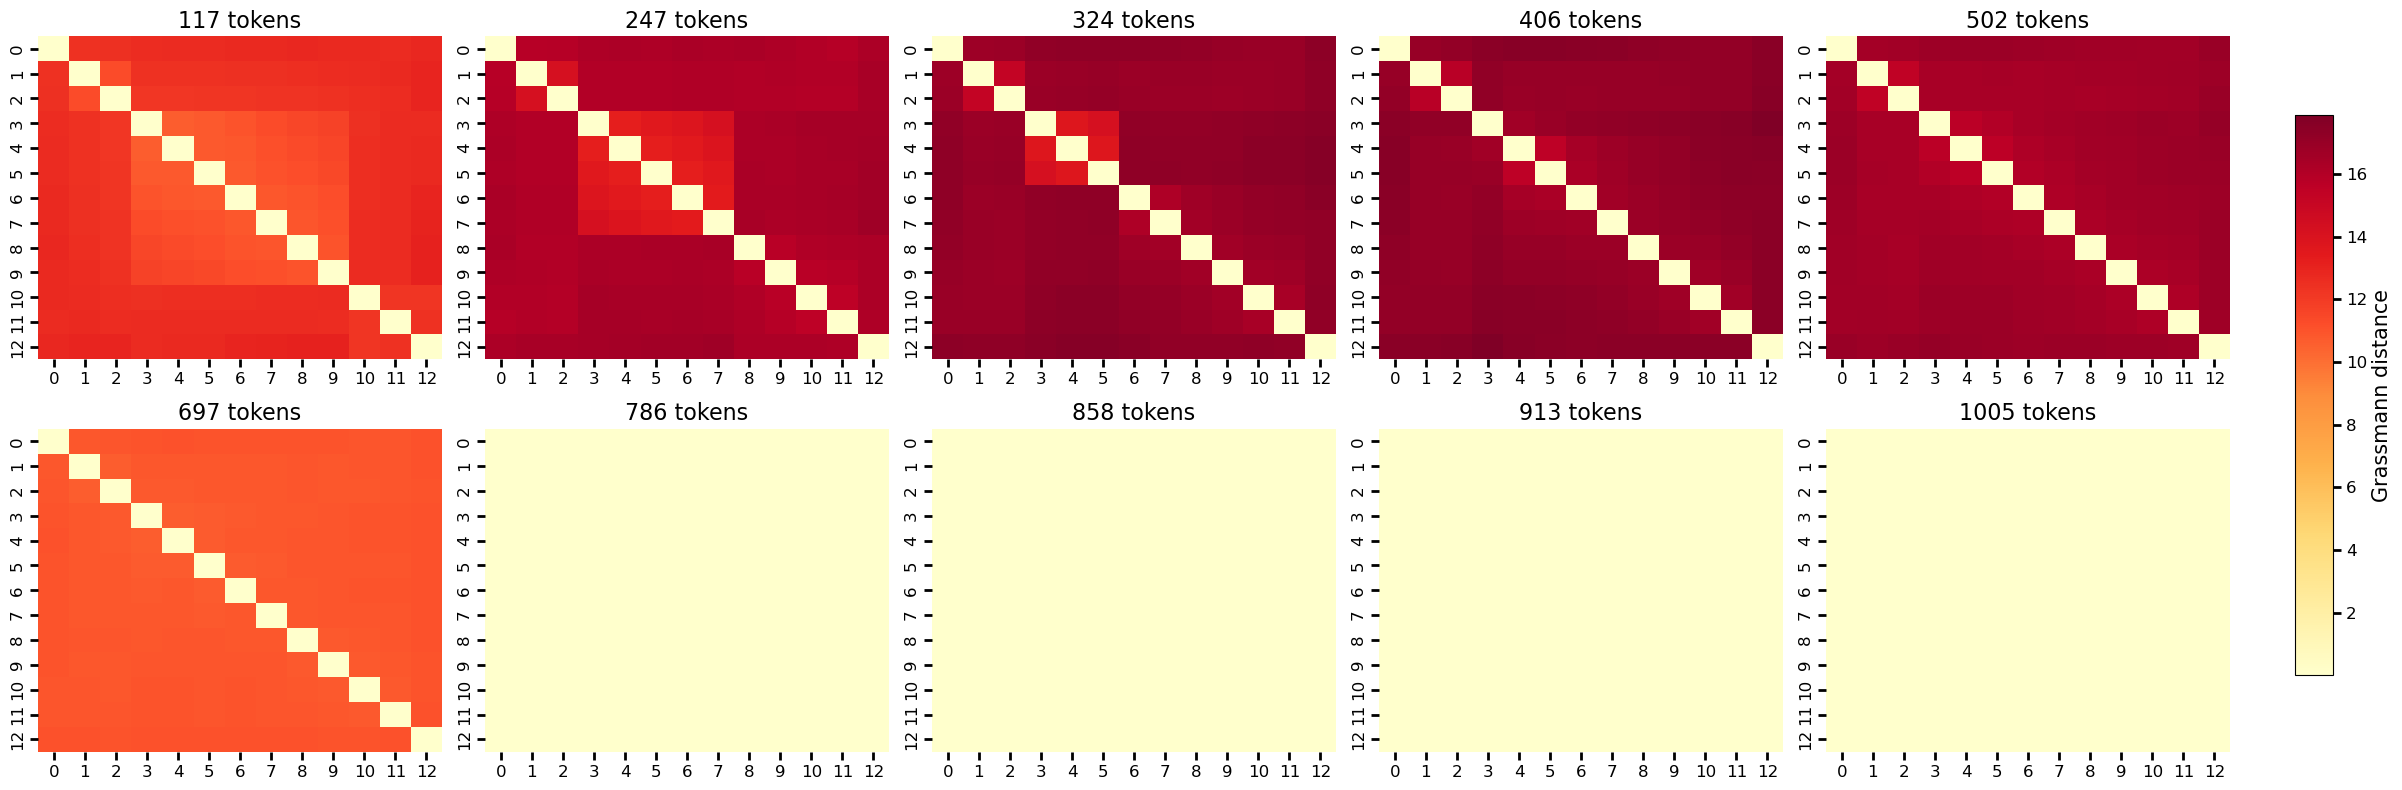

In [3]:
# Plot Volume, GD evolution and Cosine similarity
plot_geometry(volumes, token_counts, title="Volume over buffer states", xlabel="Buffer index", ylabel="log(Volume)")
plot_geometry(gd, token_counts, title="Grassmann distance from previous buffer", xlabel="Buffer index", ylabel="Grassmann distance")
plot_geometry(cos_sim, token_counts, title="Cosine similarity with last buffer", xlabel="Buffer index", ylabel="Cosine similarity")

# Plot mean vector evolution
# PCA_plot(mean_vector, token_counts)
# PCA_plot_3d(mean_vector, token_counts)

# Plot the fraction of explored space
rank_plot(rank_matrix)

# Plot the GD heatmap
plot_heatmap(gd_heatmap, token_counts)

We see that at a certain point the fraction of spanned space saturates, the Grassmann distance begins to decrease and in some cases, there appears to be no further change in orientation (as seen in the heatmaps).

# (Close to) 768 tokens prompts

In order to better understand what is happening, we decided to implement a further analysis where we created 10 prompts with a number of tokens around the value of 768, which seems to be particularly important, to see what happens to the Grassmann distance.

In [4]:
# Compute the interested geometrical quantities
volumes, gd, cos_sim, mean_vector, token_counts, rank_matrix = general_analysis("prompts_768.txt")

# prepare data for the heatmap
gd_heatmap = get_heatmap("prompts_768.txt")

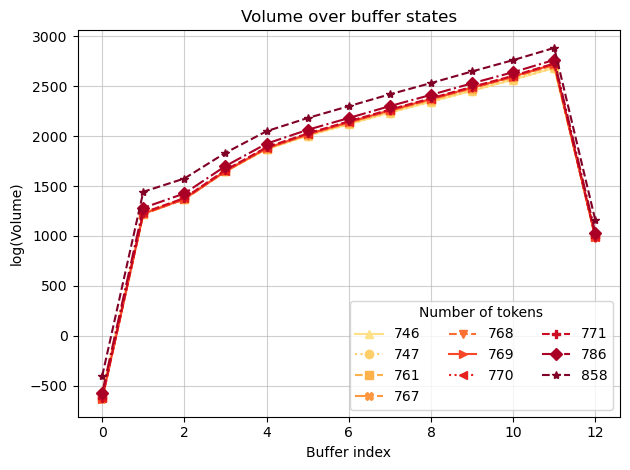

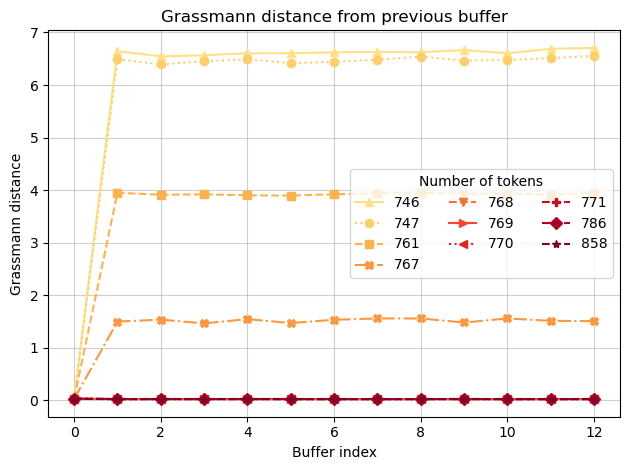

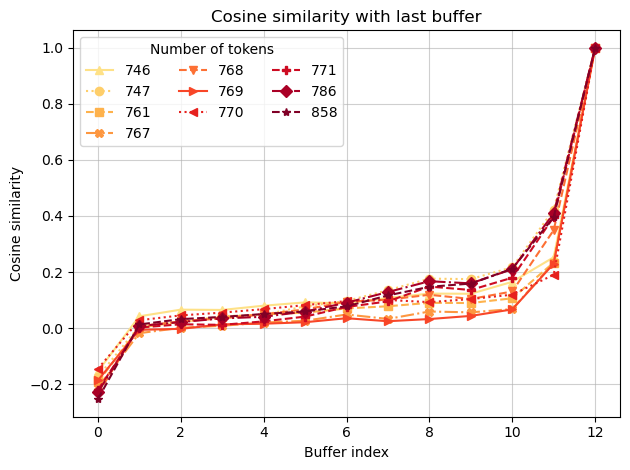

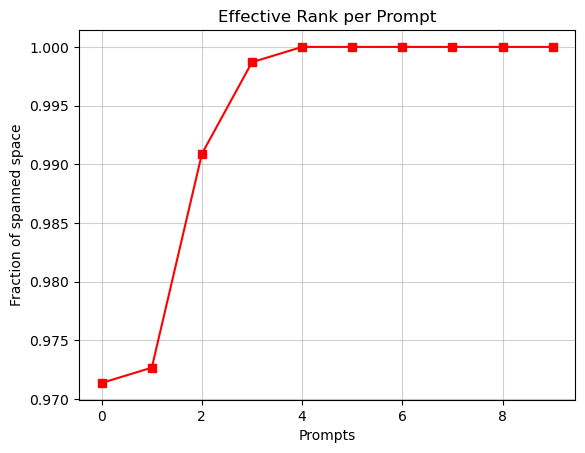

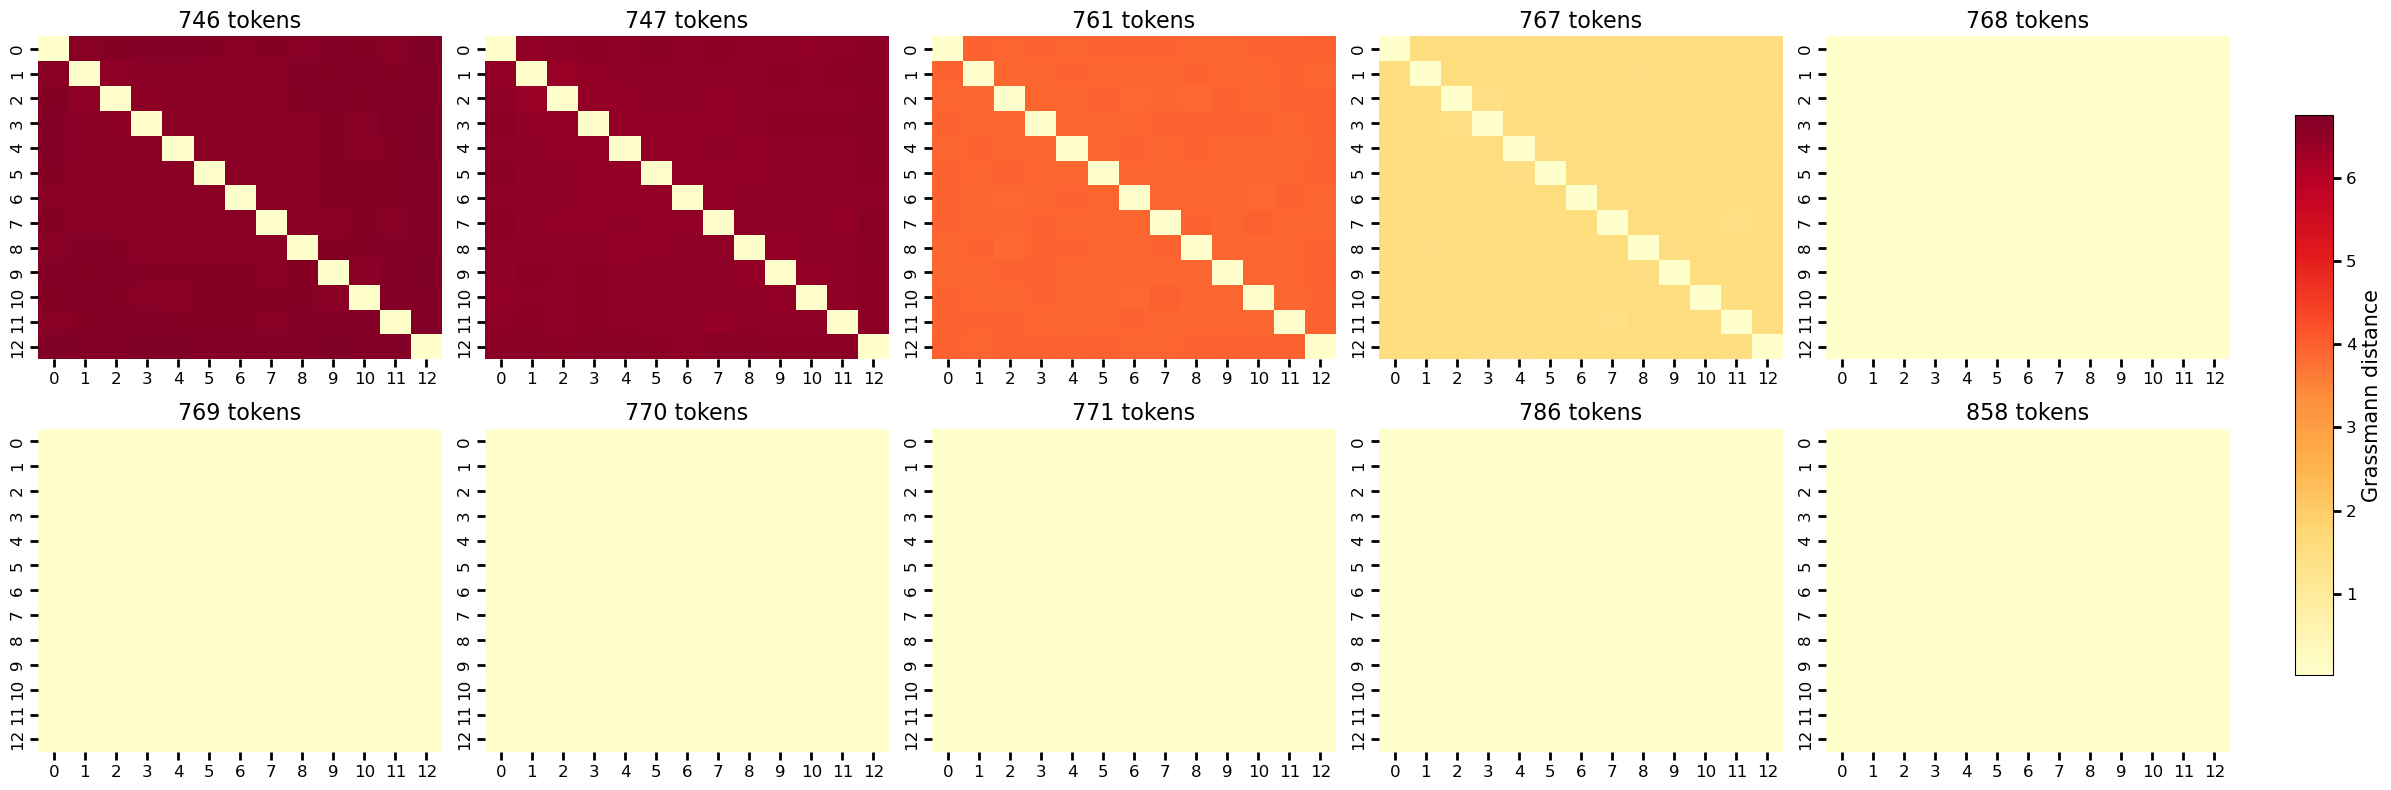

In [5]:
#Plot Volume, GD evolution and Cosine similarity
plot_geometry(volumes, token_counts, title="Volume over buffer states", xlabel="Buffer index", ylabel="log(Volume)")
plot_geometry(gd, token_counts, title="Grassmann distance from previous buffer", xlabel="Buffer index", ylabel="Grassmann distance")
plot_geometry(cos_sim, token_counts, title="Cosine similarity with last buffer", xlabel="Buffer index", ylabel="Cosine similarity")

#Plot mean vector evolution
# PCA_plot(mean_vector, token_counts)
# PCA_plot_3d(mean_vector, token_counts)

#Plot the fraction of explored space
rank_plot(rank_matrix)

#Plot the GD heatmap
plot_heatmap(gd_heatmap, token_counts)

## Search for phase transition across rank = 768

We now want to see better the transition of the average Grassmann Distance when the number of token involved is bigger than the embeddind dimension:

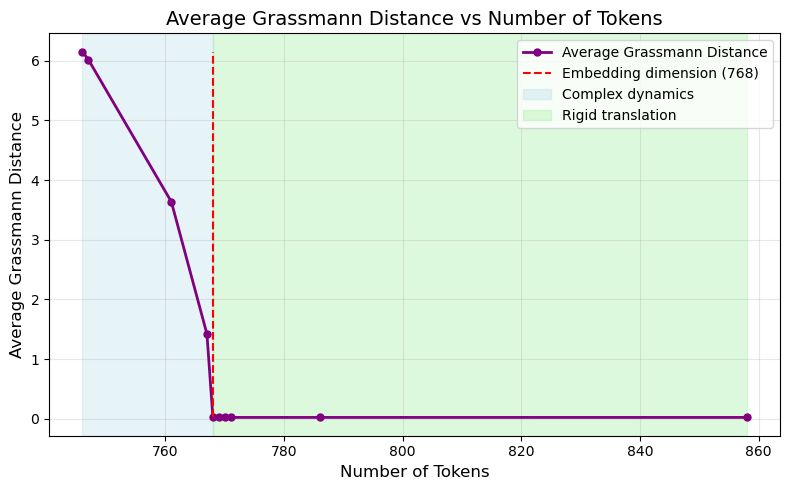

In [6]:
gd_avg = np.mean(gd_heatmap, axis=(1,2))

plt.figure(figsize=(8,5))
plt.plot(token_counts, gd_avg, marker='o', linestyle='-', color='purple', linewidth=2, markersize=5, label = 'Average Grassmann Distance')
plt.title('Average Grassmann Distance vs Number of Tokens', fontsize=14)
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Average Grassmann Distance', fontsize=12)
plt.grid(alpha=0.3)

# Vertical line at 768
plt.vlines(ymax = np.max(gd_avg), ymin = np.min(gd_avg), x = 768, linestyle = 'dashed', color = 'red', label = 'Embedding dimension (768)')

# Shaded regions
plt.axvspan(min(token_counts), 768, color='lightblue', alpha=0.3, label='Complex dynamics')
plt.axvspan(768, max(token_counts), color='lightgreen', alpha=0.3, label='Rigid translation')

plt.legend()
plt.tight_layout()
plt.show()

From this plot, we can see that the average Grassmann distance drops at zero when the number of tokens involved is greater than 768. After that point, there are no more rotations/inclinations, but it looks like the buffer moves with rigid translations. It seems (qualitatively) that there is a ”geometrical phase transition” from a complex dynamical motion to a rigid translation.

## Different context prompts

Furthermore, we tried to create 10 prompts of almost 100 tokens each, but
from different semantic areas. Here we present the couples between the
prompt index (used in the plots) and its context:

0 - Art

1 - Sport

2 - Physics

3 - Literature

4 - Philosophy

5 - Anatomy

6 - Politics

7 - Economy

8 - Cinema

9 - Mathematics

In [7]:
#Compute the interested geometrical quantities
volumes, gd, cos_sim, mean_vector, token_counts, rank_matrix = general_analysis("different_topics_prompts.txt")

#prepare data for the heatmap
gd_heatmap = get_heatmap("different_topics_prompts.txt")

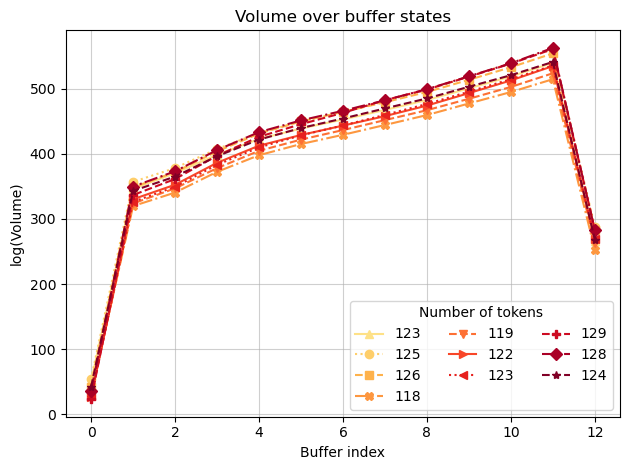

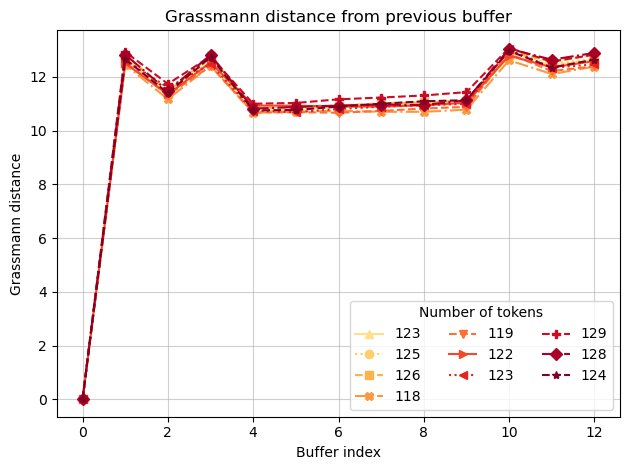

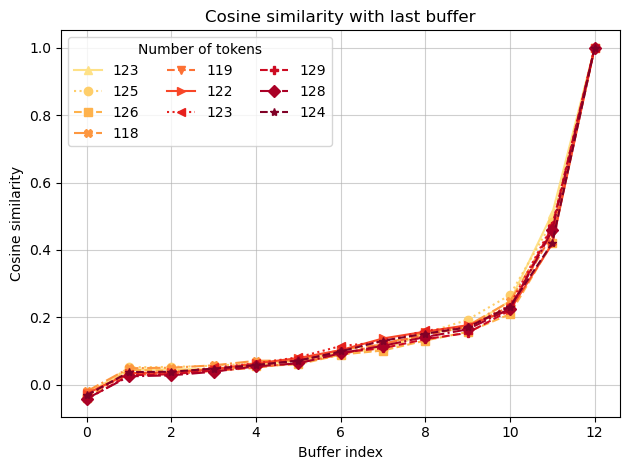

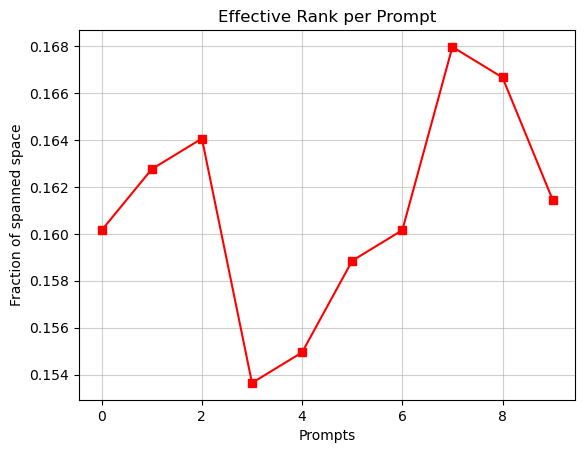

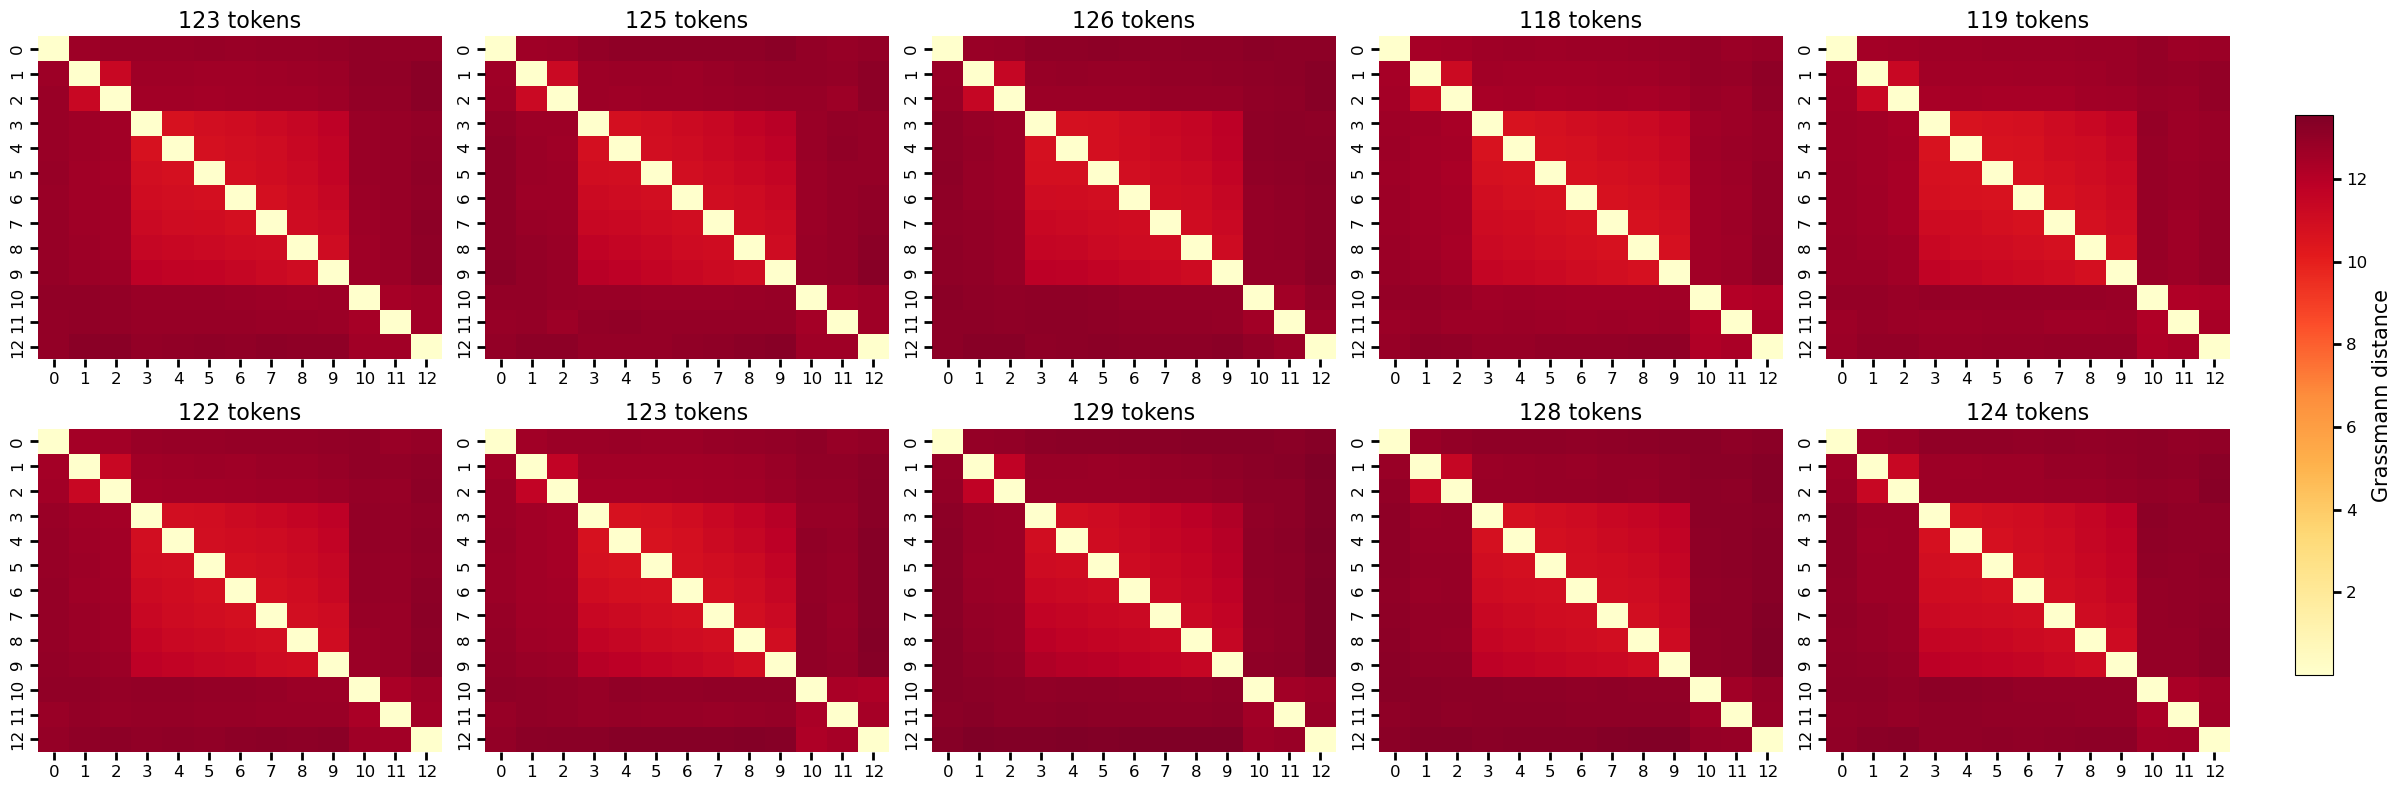

In [8]:
#Plot Volume, GD evolution and Cosine similarity
plot_geometry(volumes, token_counts, title="Volume over buffer states", xlabel="Buffer index", ylabel="log(Volume)")
plot_geometry(gd, token_counts, title="Grassmann distance from previous buffer", xlabel="Buffer index", ylabel="Grassmann distance")
plot_geometry(cos_sim, token_counts, title="Cosine similarity with last buffer", xlabel="Buffer index", ylabel="Cosine similarity")

#Plot mean vector evolution
# PCA_plot(mean_vector, token_counts)
# PCA_plot_3d(mean_vector, token_counts)

#Plot the fraction of explored space
rank_plot(rank_matrix)

#Plot the GD heatmap
plot_heatmap(gd_heatmap, token_counts)

In this case:

The curves in the first three plots (volume, Grassmann distance and
cosine similarity) are almost the same;

In the ”fraction of explored space plot”, the data points
appear to be randomly distributed, which is coherent with the fact
that we are looking at different semantic areas;

Despite that, the heatmaps are very similar between them. This could
mean that the way the spaces rotate has a certain regularity even if
they span different regions of the 768D space.